<a href="https://colab.research.google.com/github/Bushra1216/AI-Image-Generation-/blob/main/AI_Image_Generation_with_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] ='/content'    #upload json file which downloded as kaggle api token, then run it.

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [00:11<00:00, 109MB/s] 
100% 1.33G/1.33G [00:11<00:00, 120MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [ ]:
CUDA_DEVICE_NUM = 2
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:2


In [ ]:
# The directory path where dataset is located
DATA_DIR = "/content/img_align_celeba"

### Hyperparamaters
# Batch size is the number of samples processed in each iteration during training
batch_size = 1024

# Spatial size of training images, the images will be resized on that size
image_size = 64

# The number of image channels (e.g., 3 for RGB)
CHANNELS = 3

# Latent vector z , input vector to the generator
INPUT_VECTOR_DIM = 100

# The initial number of feature maps in the generator and discriminator
FEATURE_MAP_DIM = 64

# Learning rate for optimizers , 2e-4 is equal to 0.0002
LR = 2e-4

# Beta1 parameter for Adam optimizer
BETA1 = 0.5

# number of training iteration
EPOCHS = 15

# Used to ensure the sequence of random numbers generated will be same when each time the program run with that specific seed
RANDOM_SEED = 42

# to ensure the reproducable result
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device:', device)


Device: cuda


In [ ]:
dataset = ImageFolder(DATA_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(*((0.5,0.5,0.5),(0.5,0.5,0.5))),
                           ]))


dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_dim, channels):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Conv2d(channels, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.conv_2 = nn.Conv2d(feature_map_dim*2, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.conv_3 = nn.Conv2d(feature_map_dim*4, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.conv_4 = nn.Conv2d(feature_map_dim*8, feature_map_dim*16, 4, 2, 1, bias=False) #size [1024, 4, 4]
        self.conv_5 = nn.Conv2d(feature_map_dim*16, 1, 4, 1, 0, bias=False) #size [1, 1, 1]

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)
        self.sigmoid = nn.Sigmoid()


    def forward(self, inp):
        x = self.conv_1(inp)
        x = self.leaky_relu(x)

        x = self.conv_2(x)
        x = self.batch_norm_1(x)
        x = self.leaky_relu(x)

        x = self.conv_3(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu(x)

        x = self.conv_4(x)
        x = self.batch_norm_3(x)
        x = self.leaky_relu(x)

        x = self.conv_5(x)
        out = self.sigmoid(x)

        return out

In [ ]:
discriminator = Discriminator(FEATURE_MAP_DIM, CHANNELS).to(device)

x = torch.randn(batch_size, CHANNELS, image_size, image_size).to(device)
dis_out = discriminator(x)
print(dis_out.size())

torch.Size([1024, 1, 1, 1])


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels):
        super(Generator, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim, feature_map_dim*16, 4, 1, 0, bias=False) #size [1024, 4, 4]
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) #size [3, 64, 64]

        self.relu = nn.ReLU()

        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)

        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.convt_1(inp)
        x = self.batch_norm_1(x)
        x = self.relu(x)

        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)

        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)

        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)

        x = self.convt_5(x)
        out = self.tanh(x)

        return out

In [ ]:
generator = Generator(INPUT_VECTOR_DIM, FEATURE_MAP_DIM, CHANNELS).to(device)

noise = torch.randn(batch_size, INPUT_VECTOR_DIM, 1, 1, device=device)
gen_out = generator(noise)
print(gen_out.size())


torch.Size([1024, 3, 64, 64])


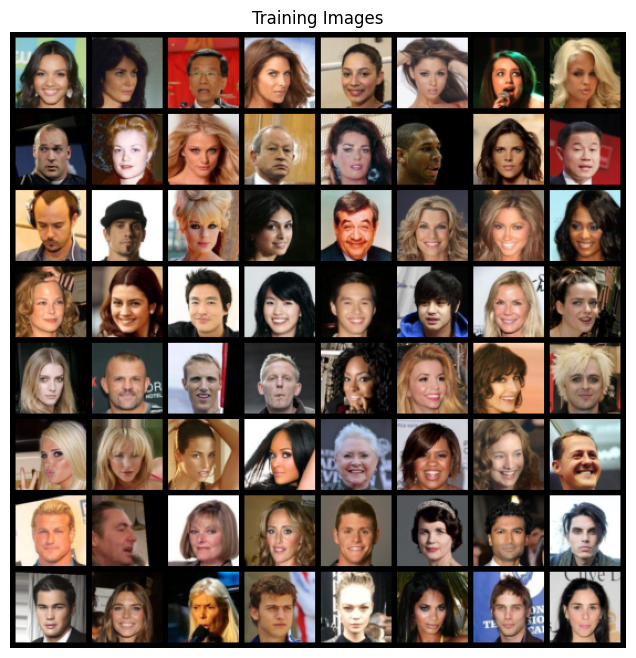

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

100%|██████████| 198/198 [23:48<00:00,  7.22s/it]


Discriminator Loss EPOCH 1: 20195.5161
Generator Loss EPOCH 1: 6.3340


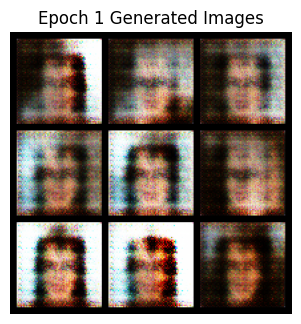

100%|██████████| 198/198 [23:54<00:00,  7.24s/it]


Discriminator Loss EPOCH 2: 22079.1526
Generator Loss EPOCH 2: 2.3272


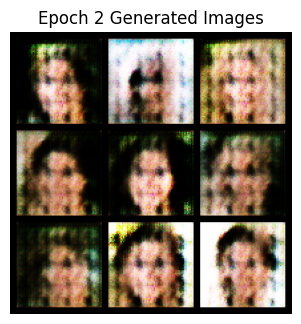

100%|██████████| 198/198 [23:56<00:00,  7.25s/it]


Discriminator Loss EPOCH 3: 20534.0764
Generator Loss EPOCH 3: 2.7325


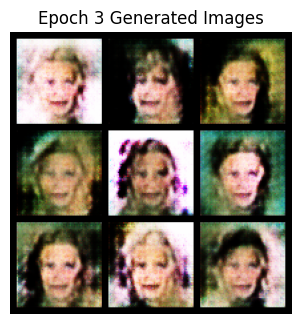

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 4: 18396.3424
Generator Loss EPOCH 4: 3.0887


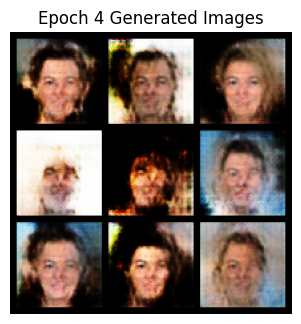

100%|██████████| 198/198 [23:54<00:00,  7.24s/it]


Discriminator Loss EPOCH 5: 17513.6657
Generator Loss EPOCH 5: 3.2555


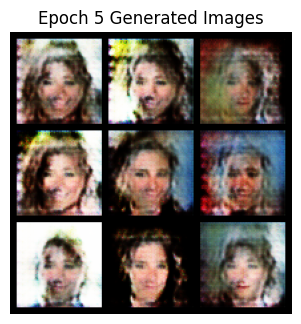

100%|██████████| 198/198 [23:54<00:00,  7.25s/it]


Discriminator Loss EPOCH 6: 17157.5527
Generator Loss EPOCH 6: 3.3609


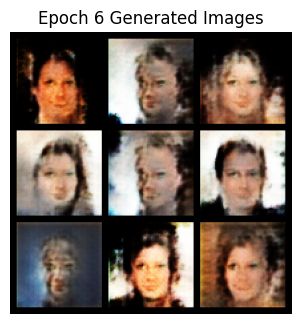

100%|██████████| 198/198 [23:56<00:00,  7.25s/it]


Discriminator Loss EPOCH 7: 17963.0766
Generator Loss EPOCH 7: 3.0854


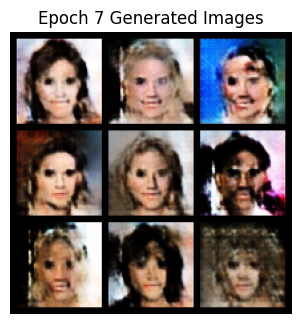

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 8: 17283.1010
Generator Loss EPOCH 8: 3.0764


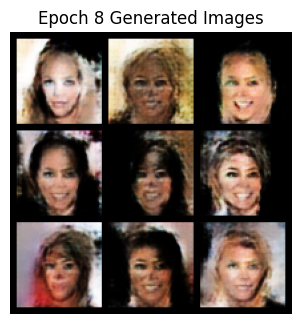

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 9: 15807.9938
Generator Loss EPOCH 9: 3.3722


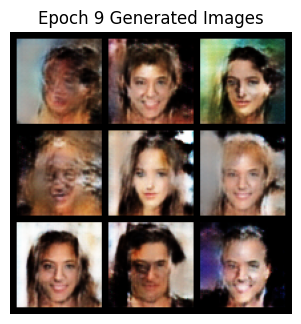

100%|██████████| 198/198 [24:01<00:00,  7.28s/it]


Discriminator Loss EPOCH 10: 14915.6178
Generator Loss EPOCH 10: 3.2928


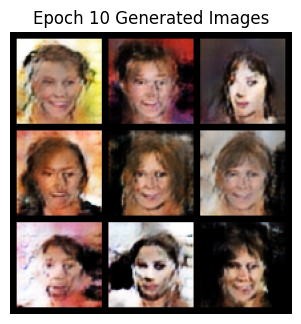

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 11: 13923.2159
Generator Loss EPOCH 11: 3.4015


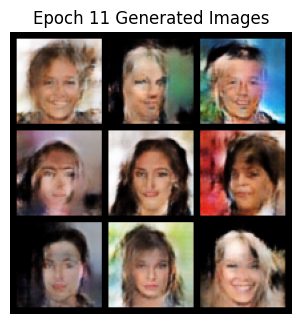

100%|██████████| 198/198 [23:58<00:00,  7.26s/it]


Discriminator Loss EPOCH 12: 13636.0551
Generator Loss EPOCH 12: 3.5301


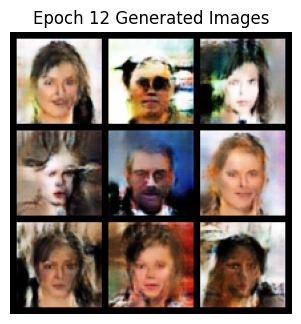

100%|██████████| 198/198 [23:58<00:00,  7.27s/it]


Discriminator Loss EPOCH 13: 12911.5331
Generator Loss EPOCH 13: 3.5851


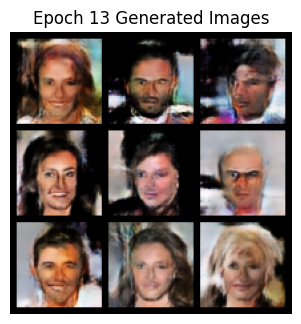

100%|██████████| 198/198 [23:56<00:00,  7.25s/it]


Discriminator Loss EPOCH 14: 12963.4694
Generator Loss EPOCH 14: 3.5436


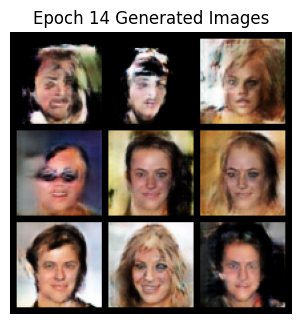

100%|██████████| 198/198 [23:53<00:00,  7.24s/it]


Discriminator Loss EPOCH 15: 12736.9993
Generator Loss EPOCH 15: 3.6225


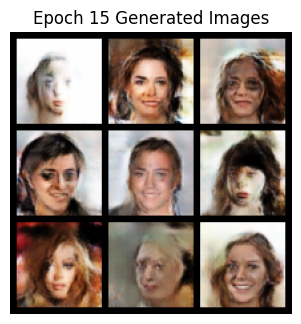

100%|██████████| 15/15 [5:59:41<00:00, 1438.78s/it]

Training Time: 21581.69s


In [ ]:
generator_losses = []
discriminator_losses = []

criterion = nn.BCELoss()

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))

generator.train()
discriminator.train()

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    generator_running_loss = 0
    discriminator_running_loss = 0
    for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)):
        img_data = data[0].to(device)  # size [1024, 3, 64, 64]
        dummy_labels = data[1]  # size [1024]

        real_labels = torch.full((dummy_labels.size()), 1., dtype=torch.float).to(device)  # size [1024]
        fake_labels = torch.full((dummy_labels.size()), 0., dtype=torch.float).to(device)
        noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)  # size [1024, 100, 1, 1]

        discriminator_real_out = discriminator(img_data).view(-1)  # size [1024] .view(-1) to rid unnecessary dimensions
        discriminator_real_loss = criterion(discriminator_real_out, real_labels)
        discriminator.zero_grad()
        discriminator_real_loss.backward()

        generator_fake_out = generator(noise)  # size [1024, 3, 64, 64]
        discriminator_fake_out = discriminator(generator_fake_out.detach()).view(-1)  # detach used because we'll calculate it for a second time
        discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels)
        discriminator_fake_loss.backward()
        discriminator_running_loss += discriminator_real_loss.item() + discriminator_fake_loss.item()
        # Update Discriminator.......
        discriminator_optimizer.step()

        discriminator_fake_out = discriminator(generator_fake_out).view(-1)  # calculated it for a second time. So that we won't have to backward graphs a second time
        generator_loss = criterion(discriminator_fake_out, real_labels)
        generator_running_loss += generator_loss.item()
        generator.zero_grad()
        generator_loss.backward()
        # Update Generator......................
        generator_optimizer.step()

    discriminator_loss = discriminator_running_loss / 2 * (idx + 1)
    generator_loss = generator_running_loss / (idx + 1)

    discriminator_losses.append(discriminator_loss)
    generator_losses.append(generator_loss)

    print(f"Discriminator Loss EPOCH {epoch+1}: {discriminator_loss:.4f}")
    print(f"Generator Loss EPOCH {epoch+1}: {generator_loss:.4f}")
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(), (1, 2, 0)))
    plt.show()

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss curves

plt.plot(generator_losses, label='Generator Loss', color='blue')
plt.plot(discriminator_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses of Generator and Discriminator')
plt.show()
# this will show the discrimiantor and generator loss